### Course Announcements

**Due Sunday (11:59 PM)**
- D6
- Q7 
- Checkpoint #1 (discuss Data section)
- Weekly Project Survey (optional)

# Text Analysis

- **Sentiment Analysis**
    - tokenization
    - stop words
    - stemming
- **TF-IDF**
    - Bag of Words
    - term frequency
    - inverse document frequency
- Tools: `nltk`

In [1]:
# pandas and matplotlib setup
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (17, 7)
plt.rcParams.update({'font.size': 14})
import seaborn as sns

#improve resolution
#comment this line if erroring on your machine/screen
%config InlineBackend.figure_format ='retina'

import warnings
warnings.filterwarnings('ignore')

#import natural language toolkit
import nltk

# download stopwords & punkt
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shannonellis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/shannonellis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#### Reminder: **Natural Language Processing** is a whole field of study.

Like most topics in this course, there are many courses solely focused on the appropriate analysis of text. We'll cover the general concepts in this course, but know you're missing lots of important details.

## Natural Language Toolkit (`nltk`)

For more details on using the functionality within this package, check out the [NLTK Book](http://www.nltk.org/book/).

0. Preface
1. Language Processing and Python
2. Accessing Text Corpora and Lexical Resources
3. Processing Raw Text
4. Writing Structured Programs
5. Categorizing and Tagging Words 
6. Learning to Classify Text
7. Extracting Information from Text
8. Analyzing Sentence Structure
9. Building Feature Based Grammars
10. Analyzing the Meaning of Sentences 
11. Managing Linguistic Data
12. Afterword: Facing the Language Challenge

[VADER](https://github.com/cjhutto/vaderSentiment) is a particularly helpful tool/lexicon when working with sentiments expressed in social media (tweets, online reviews, etc.)

Its functionality is available through `nltk`, so we'll download the vader lexicon for use later in this notebook.

In [2]:
# get lexicon we'll be working with today
nltk.download('vader_lexicon') 

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/shannonellis/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## The Data

In [3]:
quarters = ['Wi24', 'Wi21', 'Fa20', 'Wi20', 'Sp20', 'Sp19']

In [4]:
def read_data(quarter):
    '''read data in from specified quarter, extract columns of interest 
    and add a column indicating quarter from which data originated'''
    
    df = pd.read_csv('https://raw.githubusercontent.com/shanellis/datasets/master/COGS108_feedback_' + quarter + '.csv')
    df = df[['enjoyed_most', 'enjoyed_least']]
    df['quarter'] = quarter
    
    return df

In [5]:
# read in data for all quarters
df = pd.DataFrame()

for quarter in quarters:
    qtr = read_data(quarter)
    df = pd.concat([df, qtr], ignore_index=True)
    
df

,enjoyed_most,enjoyed_least,quarter
0,"The pace is moderate, easy to follow but not b...",We have to work in a group. personally speakin...,Wi24
1,I enjoy exploring data science more using Python.,"I don't really like when labs, lecture, and as...",Wi24
2,"guest lectures, being able to hear real life e...",weekly lecture quizzes,Wi24
3,"Assignment, there is a step by step guide how ...","Assignment, because its also time consuming.",Wi24
4,Coding,Group members not responding,Wi24
...,...,...,...
2290,the fact that the professor codes in class liv...,the fact that the group partners were assigned...,Sp19
2291,No exams,Team project,Sp19
2292,The availability of office hours and style of ...,I don't know much about Python and it is reall...,Sp19
2293,The availability of office hours and style of ...,I don't know much about Python and it is reall...,Sp19


## Describe & Explore

We'll quickly describe and explore the data to see what information we have before moving on to Text Analysis.

### Data Considerations

- duplicate responses?
- PIDs for individuals in the class (typos?)
- missingness?
- reflect reality?

In [6]:
# how many from each quarter?
df.value_counts('quarter')

quarter
Wi24    584
Sp20    397
Sp19    384
Fa20    321
Wi21    314
Wi20    295
dtype: int64

Note: Response Rates
- Spring 2019: 384/826 (46%)
- Winter 2020: 295/444 (66%)
- Spring 2020: 397/475 (84%)
- Fall 2020: 321/447 (72%)
- Winter 2021: 314/438 (72%)
- **Winter 2024: 584/701 (83%)**

### Missingness

In [7]:
# how many nonresponses
df.isnull().sum()

enjoyed_most     141
enjoyed_least    276
quarter            0
dtype: int64

We see that there are more nonresponses in the `enjoyed_least` category than the `enjoyed_most` category. So, more people left what they enjoyed least blank than they did what they enjoyed most.

In [8]:
# how does that look by quarter?
null_most = df.groupby('quarter')['enjoyed_most'].apply(lambda x: x.isnull().sum())
null_least = df.groupby('quarter')['enjoyed_least'].apply(lambda x: x.isnull().sum())

print(null_most, null_least)

quarter
Fa20    27
Sp19    58
Sp20    23
Wi20    33
Wi21     0
Wi24     0
Name: enjoyed_most, dtype: int64 quarter
Fa20    54
Sp19    78
Sp20    56
Wi20    64
Wi21    10
Wi24    14
Name: enjoyed_least, dtype: int64


We also see a decrease in Wi21 on. This is when I started requiring these questions (b/c I shortened the survey overall). 

#### Previous Quarters

Typically, there are a few people who have what they enjoy least but don't have an enjoy most....but often these students' feedback is of particular interest to me.

In [9]:
# overall
check_least = df[df['enjoyed_most'].isnull() & df['enjoyed_least'].notnull()]
list(check_least['enjoyed_least'])

['The PAs are a little bit challenging. I feel that lecture videos do not do a sufficient job in  preparing me for the PA',
 "Doesn't feel like the hw and lectures are solidly connected",
 'The amount of work, pace of the course, and lack of connection between python notebook and lecture videos/notebooks.',
 'The team final project',
 "The quizzes. I feel like sometimes the quiz questions are a bit more advanced from lecture, which can be a good thing, but I don't know to expect it right after just watching the lecture.",
 'I have not really enjoyed having to take a quiz after every lecture video. I personally find having to take 7-10 quizzes a week slightly excessive but I do see the value in taking the quizzes. ',
 'Seems to include a lot of important topics in data science, but only goes very briefly in every single one of them. Might be the purpose so that students are made aware of the basic concepts of such topics in data science and expected to learn deeper concepts in other con

Missing data causes a problem in `nltk`, so we either get rid of individuals who didn't respond to both, or we can replace their missing data with 'No response', knowing that this text will be included in the analysis now.

In [10]:
def fill_no_response(df):
    '''replace missing data in enjoyed_most/least series with string No response'''
    
    df['enjoyed_most'] = df['enjoyed_most'].fillna('No response')
    df['enjoyed_least'] = df['enjoyed_least'].fillna('No response')

In [11]:
# fill NAs with string 'No response'
fill_no_response(df)

## Quick checks: Words of interest



In [12]:
def check_word_freq(df, word):
    """checks for frequenccy of word specified in most and least enjoyed responses"""
    
    # calculate proportion within quarter
    word_most = df[df['enjoyed_most'].str.contains(word, case=False, na=False)]
    proportion_most = word_most.groupby('quarter').size() / df.groupby('quarter').size()
    
    word_least = df[df['enjoyed_least'].str.contains(word, case=False, na=False)]
    proportion_least = word_least.groupby('quarter').size() / df.groupby('quarter').size()
    
    out = combined_df = pd.concat([proportion_most, proportion_least], keys=['most', 'least'], axis=1)

    return out

#### Assignment

In [13]:
## check for assignment
check_word_freq(df, 'assignment')

,most,least
quarter,,
Fa20,0.171340,0.080997
Sp19,0.255208,0.117188
Sp20,0.123426,0.088161
Wi20,0.186441,0.176271
Wi21,0.200637,0.219745
Wi24,0.222603,0.239726


#### Project

In [14]:
## check for project in free text
check_word_freq(df, 'project')

,most,least
quarter,,
Fa20,0.099688,0.137072
Sp19,0.106771,0.192708
Sp20,0.085642,0.108312
Wi20,0.118644,0.091525
Wi21,0.159236,0.146497
Wi24,0.116438,0.196918


In [15]:
## check for group in free text
check_word_freq(df, 'group')

,most,least
quarter,,
Fa20,0.046729,0.056075
Sp19,0.059896,0.195312
Sp20,0.047859,0.042821
Wi20,0.037288,0.044068
Wi21,0.101911,0.108280
Wi24,0.058219,0.208904


#### Quizzes

In [16]:
check_word_freq(df, 'quiz')

,most,least
quarter,,
Fa20,0.065421,0.302181
Sp19,NaN,NaN
Sp20,0.068010,0.362720
Wi20,0.016949,0.061017
Wi21,NaN,0.089172
Wi24,0.010274,0.071918


#### Labs

In [17]:
check_word_freq(df, 'lab')

,most,least
quarter,,
Fa20,0.009346,0.006231
Sp19,0.010417,0.010417
Sp20,0.020151,0.015113
Wi20,0.010169,0.003390
Wi21,0.060510,0.076433
Wi24,0.121575,0.109589


## Sentiment Analysis

We get a quick snapshot of what's going on in COGS 108, but we really want to understand the details. To do this, analyzing the sentiment of the text is a good next step.

#### Step 1: Tokenization

Tokenization is the first step in analyzing text. 

1. Aquire text of interest
2. Break text down (tokenize) into smaller chunks (i.e. words, bigrams, sentences, etc.)

A **token** is a single entity - think of it as a building block of language.

### Tokenization Example

Here we demonstrate what a tokenized single response looks like.

In [18]:
# import regex word tokenizer
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

In [19]:
df.loc[0,'enjoyed_most']

'The pace is moderate, easy to follow but not boring.'

In [20]:
tokenized_word = tokenizer.tokenize(df.loc[0,'enjoyed_most'])
print(tokenized_word)

['The', 'pace', 'is', 'moderate', 'easy', 'to', 'follow', 'but', 'not', 'boring']


#### Tokenize COGS108 data

Using that concept we'll tokenize the words in the enjoyed_most and `enjoyed_least` columns for the data in our COGS108 data.

In [21]:
# tokenize most and least responses
df['most_token'] = df['enjoyed_most'].apply(tokenizer.tokenize) 
df['least_token'] = df['enjoyed_least'].apply(tokenizer.tokenize) 
df.head()

,enjoyed_most,enjoyed_least,quarter,most_token,least_token
0,"The pace is moderate, easy to follow but not b...",We have to work in a group. personally speakin...,Wi24,"[The, pace, is, moderate, easy, to, follow, bu...","[We, have, to, work, in, a, group, personally,..."
1,I enjoy exploring data science more using Python.,"I don't really like when labs, lecture, and as...",Wi24,"[I, enjoy, exploring, data, science, more, usi...","[I, don, t, really, like, when, labs, lecture,..."
2,"guest lectures, being able to hear real life e...",weekly lecture quizzes,Wi24,"[guest, lectures, being, able, to, hear, real,...","[weekly, lecture, quizzes]"
3,"Assignment, there is a step by step guide how ...","Assignment, because its also time consuming.",Wi24,"[Assignment, there, is, a, step, by, step, gui...","[Assignment, because, its, also, time, consuming]"
4,Coding,Group members not responding,Wi24,[Coding],"[Group, members, not, responding]"


#### Step 2: Stop Words

**Stop words** are words that are of less interest to your analysis. 

For example, you wouldn't expect the following words to be important: is, am, are, this, a, an, the, etc.

By removing stopwords, you can lower the computational burden, focusing on only the words of interest.

To do so in `nltk`, you need to create a list of stopwords and filter them from your tokens.


In [22]:
# import stop words
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# look at stop words
print(stop_words)

{'should', 'hasn', 'most', "shouldn't", 'of', 'when', 'or', 'd', 'shan', 'this', 'above', 'aren', 'which', 'them', "wasn't", 'do', 'myself', 'whom', "wouldn't", 'off', 'was', 'how', 'so', 'such', 'being', 'with', 'wouldn', 'same', "it's", 'has', 'further', 'once', 'couldn', 'between', 'yours', 'why', 'few', 'themselves', 'm', 'needn', 'out', 'during', "hasn't", 'through', 'nor', "aren't", 'down', 'haven', 'am', "haven't", 'hers', "you'll", 'mustn', 'herself', 'shouldn', 'now', 'she', 'been', 'too', 's', 'having', 'there', 'from', 'wasn', 'as', 'here', "she's", 'him', 'itself', 'other', 'you', 'our', 'than', 'against', 'what', "should've", "you're", 'can', 'over', 'ain', 'who', 'their', 'then', 'only', 'i', 'ours', 'not', 'but', 'he', 'by', "won't", 'while', 'himself', 'at', 'very', 'and', 'after', 'your', 'had', 'isn', 'on', 'is', "that'll", "isn't", 'are', 'doesn', 'll', 'be', 'were', "you'd", 'yourselves', 't', 'if', 'before', 'those', 'where', 'into', 'they', 'the', 'don', 'ourselve

### Stop Words Example

Here we compare a sentence after tokenization to one that has been tokenized _and had stop words removed_.

In [23]:
# example of removing stop words
filtered_sent=[]
for w in tokenized_word:
    if w not in stop_words:
        filtered_sent.append(w)
print("Tokenized Sentence:", tokenized_word)
print("Filtered Sentence:", filtered_sent)

Tokenized Sentence: ['The', 'pace', 'is', 'moderate', 'easy', 'to', 'follow', 'but', 'not', 'boring']
Filtered Sentence: ['The', 'pace', 'moderate', 'easy', 'follow', 'boring']


#### Remove Stop Words: COGS108 data

Using that idea, we can go ahead and remove stop words from our tokenized most and least liked tokenized data.

In [24]:
# remove stop words
df['most_stop'] = df['most_token'].apply(lambda x: [item for item in x if item not in stop_words])
df['least_stop'] = df['least_token'].apply(lambda x: [item for item in x if item not in stop_words])
df.head()

,enjoyed_most,enjoyed_least,quarter,most_token,least_token,most_stop,least_stop
0,"The pace is moderate, easy to follow but not b...",We have to work in a group. personally speakin...,Wi24,"[The, pace, is, moderate, easy, to, follow, bu...","[We, have, to, work, in, a, group, personally,...","[The, pace, moderate, easy, follow, boring]","[We, work, group, personally, speaking, I, don..."
1,I enjoy exploring data science more using Python.,"I don't really like when labs, lecture, and as...",Wi24,"[I, enjoy, exploring, data, science, more, usi...","[I, don, t, really, like, when, labs, lecture,...","[I, enjoy, exploring, data, science, using, Py...","[I, really, like, labs, lecture, assignments, ..."
2,"guest lectures, being able to hear real life e...",weekly lecture quizzes,Wi24,"[guest, lectures, being, able, to, hear, real,...","[weekly, lecture, quizzes]","[guest, lectures, able, hear, real, life, expe...","[weekly, lecture, quizzes]"
3,"Assignment, there is a step by step guide how ...","Assignment, because its also time consuming.",Wi24,"[Assignment, there, is, a, step, by, step, gui...","[Assignment, because, its, also, time, consuming]","[Assignment, step, step, guide, finish, assign...","[Assignment, also, time, consuming]"
4,Coding,Group members not responding,Wi24,[Coding],"[Group, members, not, responding]",[Coding],"[Group, members, responding]"


#### Step 3: Lexicon Normalization (**Stemming**)

In language, many different words come from the same root word. 

For example, "intersection", "intersecting", "intersects", and "intersected" are all related to the common root word - "intersect".

**Stemming** is how linguistic normalization occurs - it reduces words to their root words (and chops off additional things like 'ing') - all of the above words would be reduced to their common stem "intersect."






### Stemming Example

After tokenization and removing stop words, we can get the stem for all tokens (words) in our dataset.

In [25]:
# Stemming
from nltk.stem import PorterStemmer

ps = PorterStemmer()

stemmed_words=[]
for w in filtered_sent:
    stemmed_words.append(ps.stem(w))

print("Filtered Sentence:", filtered_sent)
print("Stemmed Sentence:", stemmed_words)

Filtered Sentence: ['The', 'pace', 'moderate', 'easy', 'follow', 'boring']
Stemmed Sentence: ['the', 'pace', 'moder', 'easi', 'follow', 'bore']


#### Stemming: COGS108 data

Here, we obtain the stem (root word) for all tokens in our dataset.

In [26]:
df['most_stem'] = df['most_stop'].apply(lambda x: [ps.stem(y) for y in x])
df['least_stem'] = df['least_stop'].apply(lambda x: [ps.stem(y) for y in x])
df.head()

,enjoyed_most,enjoyed_least,quarter,most_token,least_token,most_stop,least_stop,most_stem,least_stem
0,"The pace is moderate, easy to follow but not b...",We have to work in a group. personally speakin...,Wi24,"[The, pace, is, moderate, easy, to, follow, bu...","[We, have, to, work, in, a, group, personally,...","[The, pace, moderate, easy, follow, boring]","[We, work, group, personally, speaking, I, don...","[the, pace, moder, easi, follow, bore]","[we, work, group, person, speak, i, dont, like..."
1,I enjoy exploring data science more using Python.,"I don't really like when labs, lecture, and as...",Wi24,"[I, enjoy, exploring, data, science, more, usi...","[I, don, t, really, like, when, labs, lecture,...","[I, enjoy, exploring, data, science, using, Py...","[I, really, like, labs, lecture, assignments, ...","[i, enjoy, explor, data, scienc, use, python]","[i, realli, like, lab, lectur, assign, releas,..."
2,"guest lectures, being able to hear real life e...",weekly lecture quizzes,Wi24,"[guest, lectures, being, able, to, hear, real,...","[weekly, lecture, quizzes]","[guest, lectures, able, hear, real, life, expe...","[weekly, lecture, quizzes]","[guest, lectur, abl, hear, real, life, experi,...","[weekli, lectur, quizz]"
3,"Assignment, there is a step by step guide how ...","Assignment, because its also time consuming.",Wi24,"[Assignment, there, is, a, step, by, step, gui...","[Assignment, because, its, also, time, consuming]","[Assignment, step, step, guide, finish, assign...","[Assignment, also, time, consuming]","[assign, step, step, guid, finish, assign, by,...","[assign, also, time, consum]"
4,Coding,Group members not responding,Wi24,[Coding],"[Group, members, not, responding]",[Coding],"[Group, members, responding]",[code],"[group, member, respond]"


#### Step 4: Frequency Distribution

It can be helpful to get a sense of which words are most frequent in our dataset.

In [27]:
# get series of all most and least liked words after stemming
# note that "No Response" is still being included in the analysis
most = df['most_stem'].apply(pd.Series).stack()
least = df['least_stem'].apply(pd.Series).stack()

`FreqDist` calculates the frequency of each word in the text and we can plot the most frequent words.

In [28]:
from nltk.probability import FreqDist
import string

# calculation word frequency
fdist_most = FreqDist(most)
fdist_least = FreqDist(least)

# remove punctuation counts
for punc in string.punctuation:
    del fdist_most[punc]
    del fdist_least[punc]

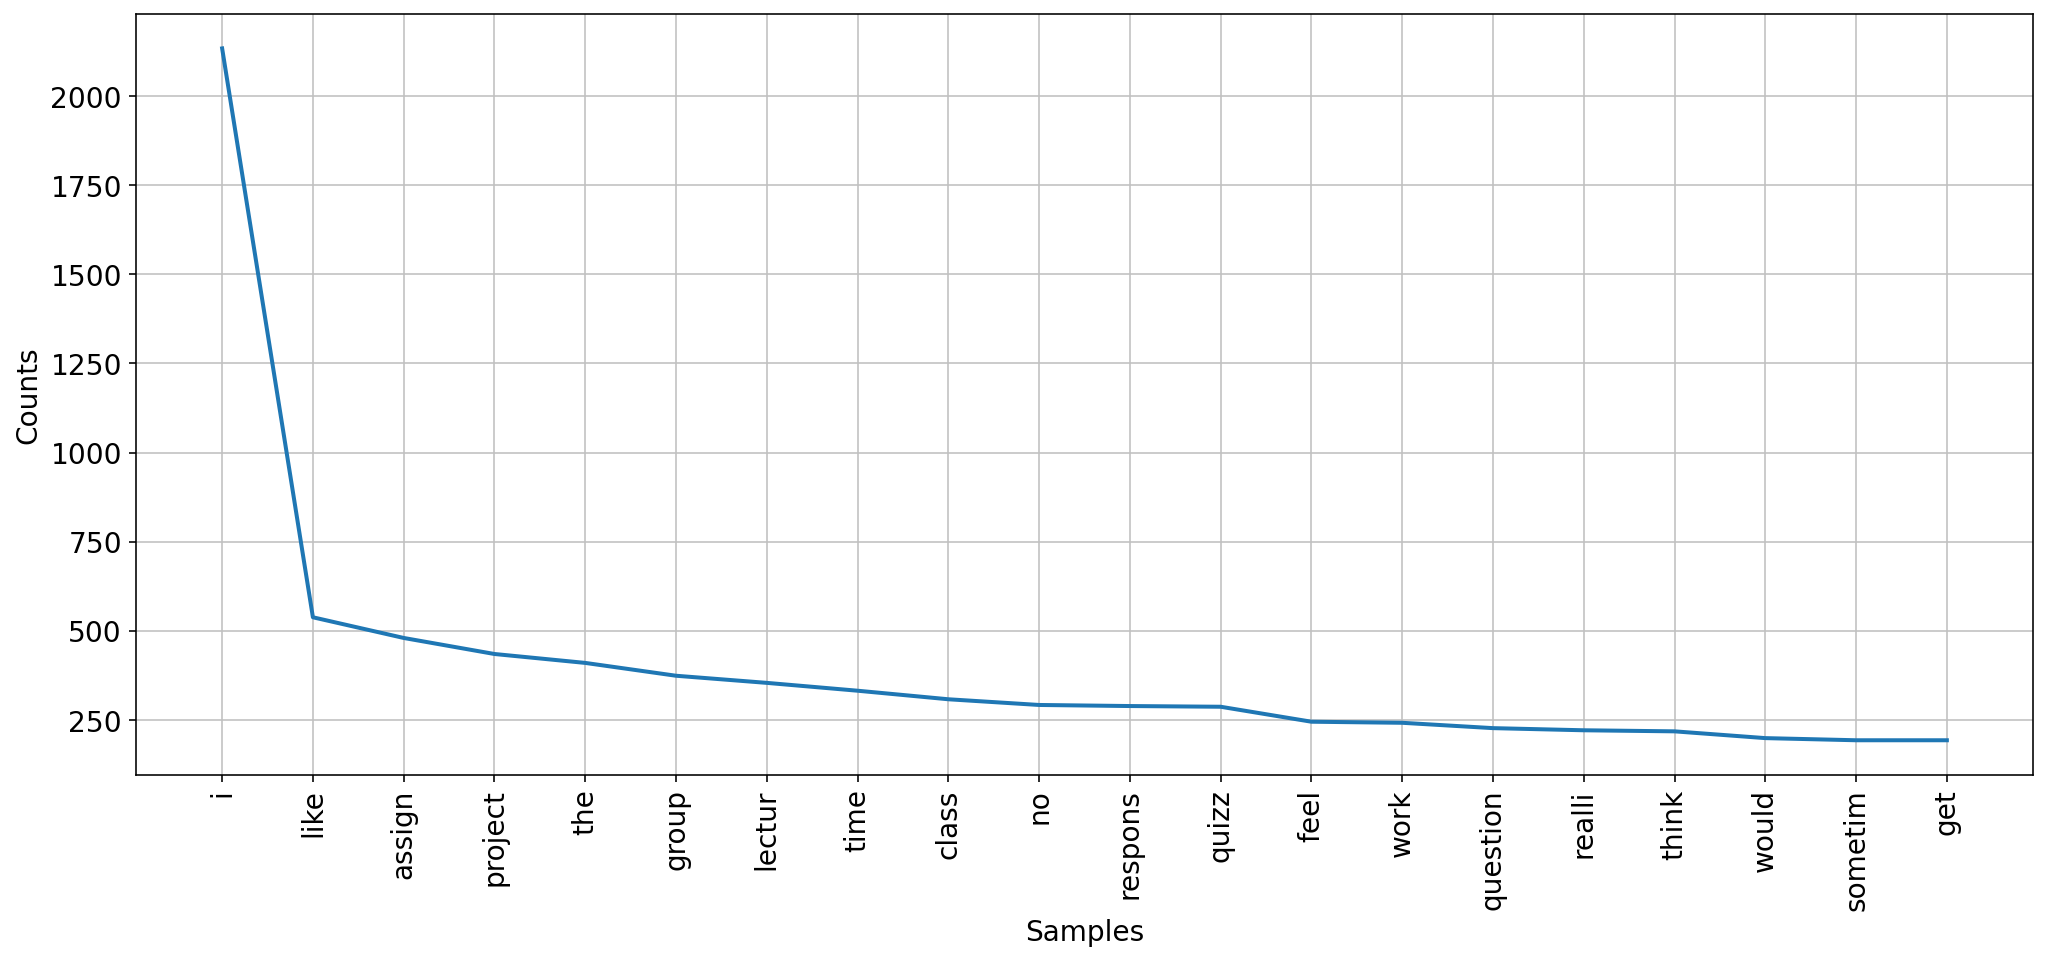

In [31]:
# Frequency Distribution Plot - top 20
# for words in what students like most
fdist_least.plot(20, cumulative=False);

#### Step 5: Sentiment Analysis!

**Sentiment Analysis** quantifies the content, idea, beliefs and opinions conveyed in text. 

Two general approaches:

1. **Lexicon-based** - count number of words in a text belonging to each sentiment (positive, negative, happy, angry, etc.)
2. **Machine learning-based** - develop a classification model on pre-labeled data



### Sentiment Example

To get a measure of overall sentiment in our text, we'll compare our text to the VADER lexicon.

In [32]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
analyser = SentimentIntensityAnalyzer()

VADER handles:

- capitalization (great vs GREAT) & punctuation (exclamation makes more positive!)
- emojis and emoticons
- degree modifiers (extremely good vs. marginally good)
- contractions and conjunctions (but signals shift)

`pos` + `neg` + `neu` = 1

**`compound`** score - metric that calculates sum of all the lexicon ratings and normalizes between -1 (most extreme negative) and +1 (most extreme positive)
- positive: `compound` >= 0.05 
- neutral: -0.05 < `compound` < 0.05
- negative : `compound` <= -0.05

In [33]:
analyser.polarity_scores("The class is super cool.")

{'neg': 0.0, 'neu': 0.326, 'pos': 0.674, 'compound': 0.7351}

In [34]:
analyser.polarity_scores("The class is not super cool.")

{'neg': 0.561, 'neu': 0.439, 'pos': 0.0, 'compound': -0.6259}

In [35]:
analyser.polarity_scores("The class is NOT super cool!")

{'neg': 0.574, 'neu': 0.426, 'pos': 0.0, 'compound': -0.6597}

#### Sentiment Analysis: COGS108 data

Here, we will calculate the sentiment of each most liked and least liked student response from the survey.

In [36]:
# get list of the 'sentences' (responses) from each individual
most_list = list(df[df['quarter'] == 'Wi24']['enjoyed_most'].values)
least_list = list(df[df['quarter'] == 'Wi24']['enjoyed_least'].values)

In [37]:
# create function that will output dataframe 
# that stores sentiment information
def get_sentiments(input_list):
    
    output = pd.DataFrame()

    for sentence in input_list:
        ss = analyser.polarity_scores(sentence)
        ss['sentence'] = sentence
        # Note use of pd.concat
        output = pd.concat([output, pd.DataFrame([ss])], ignore_index=True)


    return output

In [38]:
# get sentiment measures
least_sentiments = get_sentiments(least_list)
most_sentiments = get_sentiments(most_list)

#### Sentiment Analysis: COGS108 data output

After calculating the sentiment of each response, we can look at the output of each.

In [39]:
# let's get rid of those no response values here
most_sentiments = most_sentiments[most_sentiments['sentence'] != 'No response']
least_sentiments = least_sentiments[least_sentiments['sentence'] != 'No response']

In [41]:
# take a look at the output
least_sentiments.sort_values(by='compound', ascending=True).head(10)

,neg,neu,pos,compound,sentence
329,0.189,0.811,0.000,-0.9422,"I am generally struggling with assignments, bu..."
280,0.148,0.829,0.022,-0.9195,Personally I'm not the best at coding and the ...
349,0.147,0.853,0.000,-0.8202,"I don't like how much work there is, especiall..."
65,0.200,0.800,0.000,-0.8173,Struggled with the assignment. Because I have ...
436,0.150,0.803,0.047,-0.8039,So far the discussion activities haven't been ...
364,0.108,0.878,0.014,-0.7984,I think sometimes some of the labs are difficu...
315,0.138,0.862,0.000,-0.7657,My least favorite part of the class so far has...
365,0.169,0.831,0.000,-0.7580,I find many of the discussion assignments to b...
460,0.256,0.744,0.000,-0.7340,I think D3 was very stressful for me since I w...
547,0.303,0.697,0.000,-0.7247,I don't really have any negative experience so...


In [43]:
# take a look at the output
most_sentiments.sort_values(by='compound', ascending=False).head(10)

,neg,neu,pos,compound,sentence
43,0.031,0.624,0.346,0.9876,I enjoy lectures in Cogs 108. I think the prof...
364,0.000,0.724,0.276,0.9736,I enjoy the content—it's really interesting to...
398,0.000,0.758,0.242,0.9640,I have really enjoyed learning the basics of g...
97,0.000,0.713,0.287,0.9589,I've enjoyed attending lectures the most becau...
428,0.000,0.852,0.148,0.9589,What I've enjoyed most about COGS 108 so far i...
107,0.000,0.592,0.408,0.9578,I have enjoyed learning more about python and ...
500,0.000,0.615,0.385,0.9571,I have enjoyed the group project. I have been ...
269,0.000,0.749,0.251,0.9544,I've really enjoyed our hands-on work with pyt...
258,0.000,0.695,0.305,0.9538,- good organization of content -> very good re...
422,0.000,0.727,0.273,0.9509,"Working in group projects is fun, and I enjoy ..."


#### Sentiment Analysis: COGS108 data - `describe`

To get an overall sense of the values stored in each of these dataframes, we can use `describe`.

In [44]:
most_sentiments.describe()

,neg,neu,pos,compound
count,584.000000,584.000000,584.000000,584.000000
mean,0.010789,0.776896,0.212317,0.510628
std,0.039681,0.149374,0.147439,0.330710
min,0.000000,0.238000,0.000000,-0.634100
25%,0.000000,0.685000,0.118750,0.361200
50%,0.000000,0.774500,0.215500,0.557100
75%,0.000000,0.870000,0.301250,0.777800
max,0.487000,1.000000,0.762000,0.987600


In [45]:
least_sentiments.describe()

,neg,neu,pos,compound
count,570.000000,570.000000,570.000000,570.000000
mean,0.088686,0.833263,0.078070,0.024846
std,0.112837,0.136770,0.110833,0.432874
min,0.000000,0.253000,0.000000,-0.942200
25%,0.000000,0.756000,0.000000,-0.318200
50%,0.055500,0.840000,0.000000,0.000000
75%,0.132750,0.935750,0.128000,0.381725
max,0.662000,1.000000,0.604000,0.978400


#### Sentiment Analysis: COGS108 data - plotting

We can compare the distribution of the `compound` metric between the two analyses.

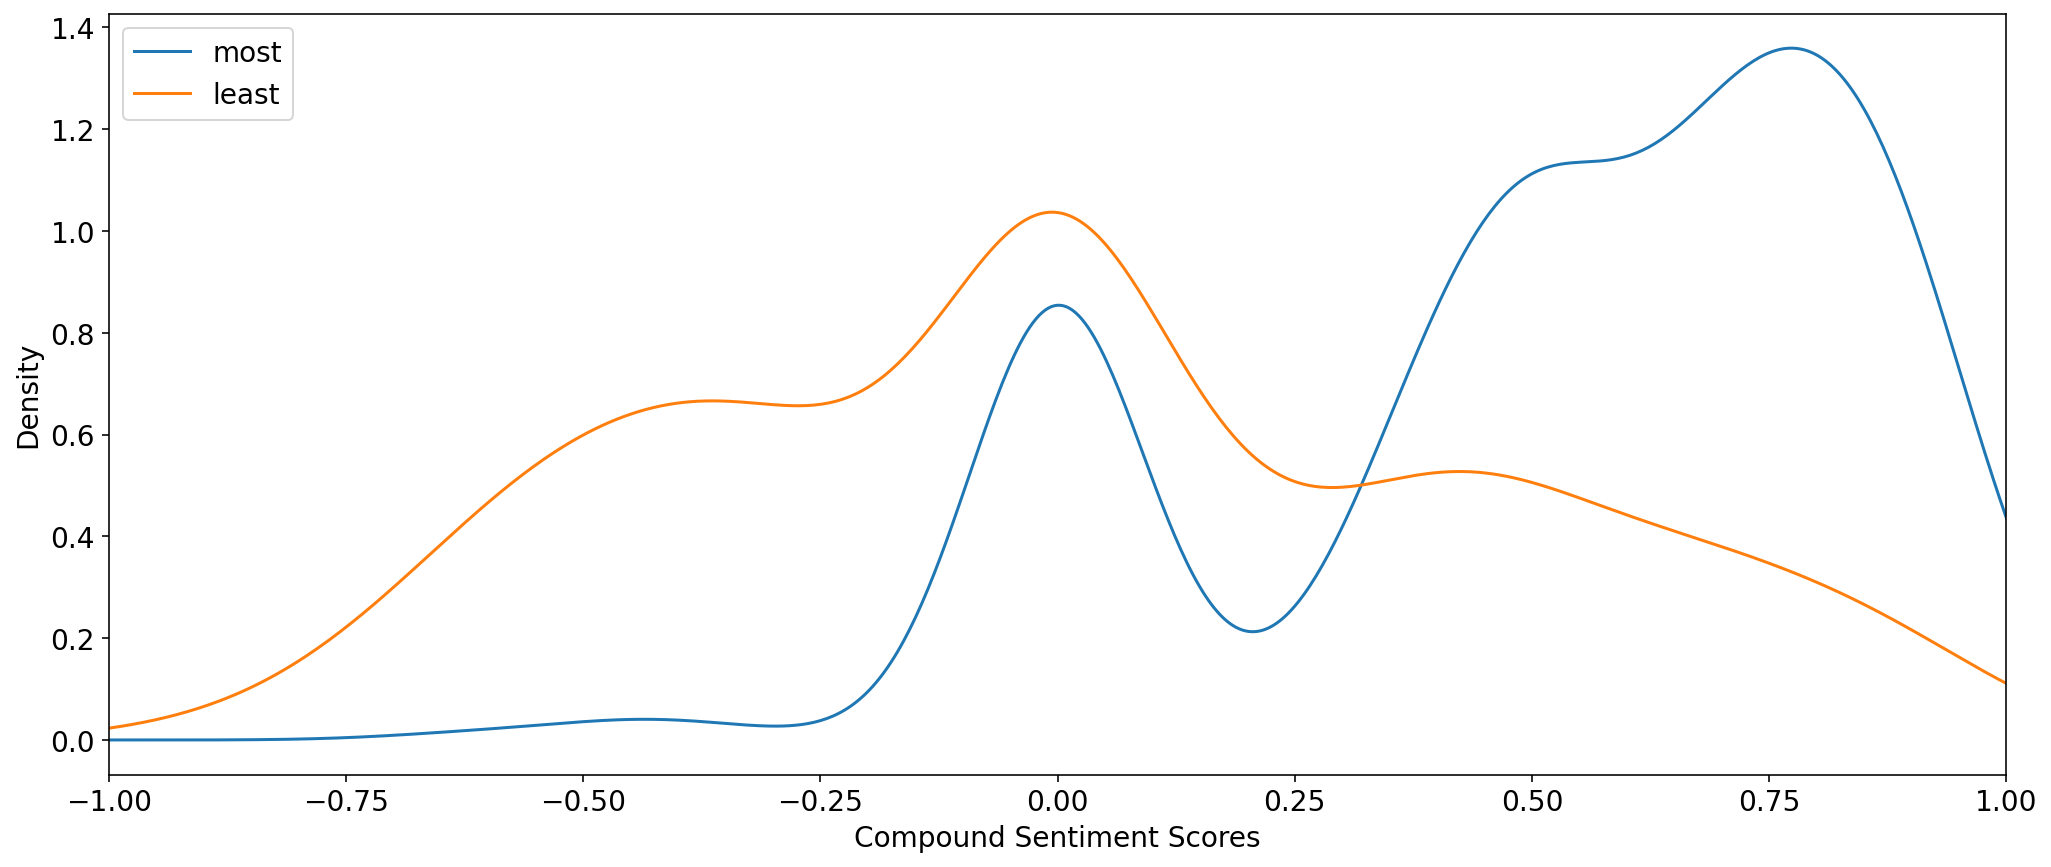

In [46]:
most_sentiments['compound'].plot.density(label='most')
least_sentiments['compound'].plot.density(label='least')
plt.legend()
plt.xlabel('Compound Sentiment Scores')
plt.xlim(-1,1);

In [47]:
# include label for boxplot
most_sentiments['which'] = 'most'
least_sentiments['which'] = 'least'
# concatenate data frames together
compound_out = pd.concat([most_sentiments, least_sentiments])
compound_out.head()

,neg,neu,pos,compound,sentence,which
0,0.0,0.646,0.354,0.5256,"The pace is moderate, easy to follow but not b...",most
1,0.0,0.652,0.348,0.4939,I enjoy exploring data science more using Python.,most
2,0.0,0.781,0.219,0.4215,"guest lectures, being able to hear real life e...",most
3,0.0,0.848,0.152,0.5267,"Assignment, there is a step by step guide how ...",most
4,0.0,1.000,0.000,0.0000,Coding,most


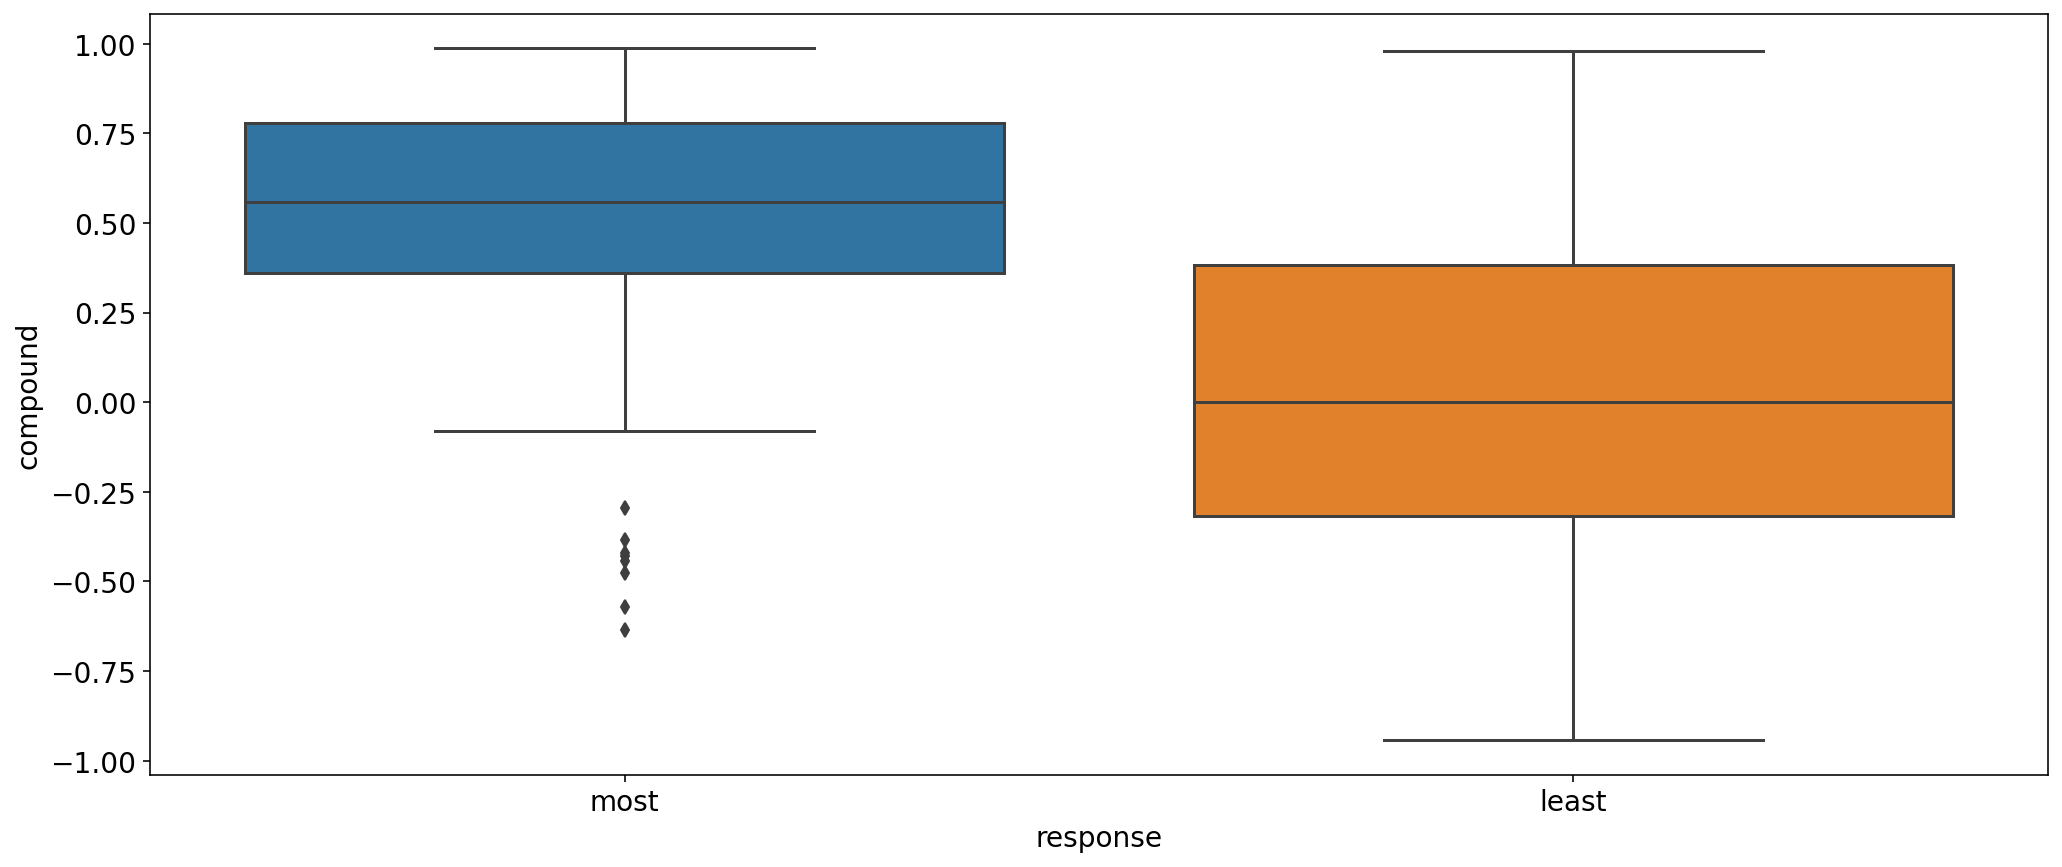

In [48]:
# plot compound by resonse type
sns.boxplot(data=compound_out, x='which', y='compound')
plt.xlabel('response');

Probably unsurprisingly, the overall sentiment of what students like tends to be more positive than what students like less. 

Probably not surprising given the data and question on the survey. But, let's dig deeper into these data moving beyond sentiment analysis...

## TF-IDF

Term Frequency - Inverse Document Frequency (**TF-IDF**) sets out to identify the tokens most unique to your document of interest (relative to all documents in your corpus). 

**Term Frequency (TF)** - counts the number of words (tokens) occurring in each document.

**Inverse Document Frequency (IDF)** - weights the word by their relative frequency across documents. 

$$IDF_{word} = log(\frac{\# documents}{\# \ documents\_containing\_word})$$

$$TF-IDF = TF \times IDF$$

words with a high TF-IDF are those with high frequency in one document & relatively low frequency in other documents

For our purposes, our **corpus** will be students' responses to what they like most and least about COGS108.

We'll treat this as **two separate documents**:
1. What students like most
2. What students like least

### Bag of Words (BoW) approach

Converts the text into a co-occurrence matrix across documents within the corpus.

To do this, let's get our text ready.

We're going to make sure all our words are lower case, remove punctuation from each, and then provide the text (`corpus`) to `TfidfVectorizer`.

In [49]:
import string 

# lowercase text
least = list(map(str.lower, least_list))
most = list(map(str.lower, most_list))

# remove punctuation
for c in string.punctuation:
    least = str(least).replace(c, "")
    most = str(most).replace(c, "")

# get list of two documents together
corpus = [str(least), str(most)]

### Calculate TF-IDF

With our text ready for analysis, it's time to calculate TF-IDF

To start our TF-IDF analysis, we'll first **create a `TfidfVectorizer` object to transform our text data into vectors.**

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [51]:
# create vectorizer
tfidf = TfidfVectorizer(sublinear_tf=True,
                        analyzer='word',
                        max_features=2000,
                        tokenizer=tokenizer.tokenize,
                        stop_words=stop_words)

#### TF-IDF: COGS108 data - calculation

Here, we use our vectorizer to calculate TF-IDF across the words in our word matrix.

In [52]:
# calculate TF-IDF
cogs_tfidf = pd.DataFrame(tfidf.fit_transform(corpus).toarray())
cogs_tfidf.columns = tfidf.get_feature_names()
cogs_tfidf = cogs_tfidf.rename(index={0:'least', 1:'most'})

#### TF-IDF: COGS108 data - output

If we just want to look at the word most uniuqe in each document...

In [53]:
most_unique = cogs_tfidf.idxmax(axis=1) 
most_unique

least    least
most      data
dtype: object

Alternatively, we can sort by the set or words most unique to each document:

In [54]:
cogs_tfidf.sort_values(by='most', axis=1, ascending=False)

,data,enjoyed,learning,like,assignments,really,science,python,class,enjoy,...,lives,llms,load,lol,longer,looked,loss,lost,lower,zone
least,0.049167,0.037958,0.045702,0.066920,0.065286,0.059101,0.036894,0.044637,0.059983,0.042144,...,0.015701,0.015701,0.026584,0.015701,0.037466,0.015701,0.015701,0.037466,0.015701,0.015701
most,0.081532,0.077169,0.076651,0.074243,0.073776,0.070665,0.068691,0.067958,0.067958,0.065822,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [55]:
cogs_tfidf.sort_values(by='least', axis=1, ascending=False)

,least,confusing,like,group,assignments,project,wish,dont,trying,think,...,relationships,relaxed,relaxing,relearning,demonstrations,demonstrate,delved,reminder,delivered,linkedin
least,0.083488,0.068019,0.066920,0.065461,0.065286,0.063982,0.062736,0.062043,0.06193,0.060124,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
most,0.000000,0.000000,0.074243,0.057129,0.073776,0.062567,0.000000,0.044708,0.00000,0.060826,...,0.017626,0.017626,0.029843,0.017626,0.017626,0.017626,0.017626,0.017626,0.017626,0.017626


**Sentiment Analysis** and **TF-IDF** are really helpful when analyzing documents and corpuses of text.

But, what if, from the text itself we wanted to predict whether or not the text was likely a 'most' liked or a 'least' liked comment? We'll discuss how to do this in the coming **machine learning** lectures!